

# Instalando bibliotecas, definindo funções e puxando os arquivos DICOM

In [ ]:
!apt update
from google.colab import drive
import os

drive.mount('/content/drive')

!pip install opencv-python-headless
!pip install pydicom
import pydicom
import pandas as pd

!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install pillow
!pip install numpy
!pip install openpyxl

import pytesseract
import numpy as np
from PIL import Image
from PIL import ImageGrab

from typing import List
from PIL import Image

import ipywidgets as widgets

import os
import re
import time
import cv2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [664 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,617 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:

In [ ]:
def replace_value(dataframe, row_index, column_name, new_value) -> pd.DataFrame:
    """
    Substitua o valor de uma coluna especificada em uma linha especificada em um DataFrame.

    Parâmetros:
    dataframe (pd.DataFrame): DataFrame original.
    row_index (int): índice da linha onde o valor será substituído.
    column_name (str): nome da coluna onde o valor será substituído.
    new_value: novo valor a ser inserido.

    Retorna:
    pd.DataFrame: DataFrame após a substituição do valor.
    """

    dataframe.at[row_index, column_name] = new_value
    return dataframe


def normalize_image(img: np.ndarray, epsilon: float = 1e-8) -> np.ndarray:
    img_min, img_max = img.min(), img.max()
    img_norm = (img - img_min) / (img_max - img_min + epsilon) * 255
    return img_norm.astype(np.uint8)

# # Função para combinar uma lista de imagens PIL
# def combine_images_vertically(pil_images):
#     combined_width = max([img.width for img in pil_images])
#     combined_height = sum([img.height for img in pil_images])

#     combined_image = Image.new('RGB', (combined_width, combined_height))

#     y_offset = 0
#     for img in pil_images:
#         combined_image.paste(img, (0, y_offset))
#         y_offset += img.height

#     return combined_image

def combine_images_vertically(pil_images: List[Image.Image]) -> Image.Image:
    combined_width = max([img.width for img in pil_images])
    combined_height = sum([img.height for img in pil_images])

    combined_image = Image.new('RGB', (combined_width, combined_height))

    y_offset = 0
    for img in pil_images:
        img = img.convert('RGB')  # Certifique-se de que a imagem está no modo RGB
        combined_image.paste(img, (0, y_offset))
        y_offset += img.height

    return combined_image

def get_dicom_header_info(dicom_file, tag):
    """
    Função para extrair uma informação específica do cabeçalho DICOM.

    Args:
        dicom_file (str): Caminho para o arquivo DICOM.
        tag (tuple): Tag DICOM no formato (grupo, elemento), por exemplo, (0x0010, 0x0010) para o nome do paciente.

    Returns:
        O valor associado à tag DICOM ou None se a tag não for encontrada no arquivo.
    """
    ds = pydicom.dcmread(dicom_file)

    if tag in ds:
        return ds[tag].value
    else:
        return None

def dicom_metadata_to_dataframe(file_path):
    # Ler o arquivo DICOM
    dicom_file = pydicom.dcmread(file_path)

    # Criar um dicionário vazio para armazenar os metadados do cabeçalho DICOM
    metadata_dict = {}

    # Iterar sobre os elementos do arquivo DICOM
    for data_element in dicom_file:
        # Obter a tag, o nome da tag (keyword) e o valor do elemento
        tag = str(data_element.tag)
        keyword = pydicom.datadict.keyword_for_tag(data_element.tag)
        value = data_element.value

        # Armazenar o valor no dicionário usando a tag e a keyword como chave
        metadata_dict[f"{tag} ({keyword})"] = value

    # Converter o dicionário em um DataFrame
    metadata_df = pd.DataFrame.from_dict(metadata_dict, orient='index', columns=['Value'])

    return metadata_df

def extrair_info_apos_palavra(texto, palavra_chave):
    regex_pattern = r'(?<=' + re.escape(palavra_chave) + r')\s*([\d.]+)'
    numeros = re.findall(regex_pattern, texto)

    if numeros:
        # Retorna o primeiro número encontrado após a palavra-chave
        return numeros[0]
    else:
        return None

def extrair_informacao(texto, string1, string2):
    try:
        inicio = texto.find(string1) + len(string1)
        final = texto.find(string2, inicio)
        resultado = texto[inicio:final].strip()
        return resultado
    except Exception as e:
        print(f"Erro ao extrair informação: {e}")
        return None

def converter_coluna_data(coluna):
    formato_entrada = "%d-%b-%y %H:%M:%S"
    formato_saida = "%d/%m/%Y"

    # Aplica a conversão a cada elemento da coluna e retorna a nova coluna
    return coluna.apply(lambda data_str: datetime.strptime(data_str, formato_entrada).strftime(formato_saida))

def renomear_arquivos(diretorio):
    arquivos = [f for f in os.listdir(diretorio) if os.path.isfile(os.path.join(diretorio, f))]

    # Ordena os arquivos usando o nome completo do arquivo
    arquivos.sort(key=lambda x: (os.path.splitext(x)[0], os.path.splitext(x)[1]))

    # Primeiro passo: renomear todos os arquivos para nomes temporários
    arquivos_temporarios = []
    for i, arquivo in enumerate(arquivos):
        nome_antigo = os.path.join(diretorio, arquivo)
        extensao = os.path.splitext(arquivo)[1]
        nome_temporario = os.path.join(diretorio, f"tmp_{i}{extensao}")

        os.rename(nome_antigo, nome_temporario)
        arquivos_temporarios.append(nome_temporario)

    # Segundo passo: renomear os arquivos temporários para a sequência correta
    for i, arquivo_temp in enumerate(arquivos_temporarios):
        nome_antigo = arquivo_temp
        extensao = os.path.splitext(arquivo_temp)[1]
        nome_novo = os.path.join(diretorio, f"{i}{extensao}")

        os.rename(nome_antigo, nome_novo)
        print(f"Arquivo '{nome_antigo}' renomeado para '{nome_novo}'")

def extrair_minutos(string):
    # Define a expressão regular para encontrar um número seguido de "min"
    pattern = r"(\d+\.?\d*)min"

    # Procura na string pela expressão regular
    match = re.search(pattern, string)

    # Se encontrar a expressão regular, retorna o número encontrado
    if match:
        return float(match.group(1))
    else:
        return None

def extrair_dose(string):
    # Define a expressão regular para encontrar um número seguido de "min"
    pattern = r"(\d+\.?\d*)mGy"

    # Procura na string pela expressão regular
    match = re.search(pattern, string)

    # Se encontrar a expressão regular, retorna o número encontrado
    if match:
        return float(match.group(1))
    else:
        return None

def mostra_botoes ():
  display(ano_escolhido, mes_escolhido,semana_escolhida)
  return

def vetores_para_dataframe(*vetores, colunas=None):
    # Criando um dicionário vazio para armazenar os vetores como colunas
    colunas_dict = {}

    # Verificando se os nomes das colunas foram fornecidos, caso contrário, usar nomes padrão
    if colunas is None:
        colunas = [f'coluna_{i}' for i in range(len(vetores))]

    # Adicionando cada vetor como uma coluna no dicionário
    for nome_coluna, vetor in zip(colunas, vetores):
        colunas_dict[nome_coluna] = vetor

    # Criando um DataFrame a partir do dicionário de colunas
    dataframe = pd.DataFrame(colunas_dict)

    return dataframe

def combine_images_vertically_cv(images):
    images_np = [np.array(img) for img in images]
    return cv2.vconcat(images_np)

def mostra_botoes_2 ():
  display(linha_escolhida, coluna_escolhida, valor_novo)
  return

In [ ]:
ano_escolhido = widgets.ToggleButtons(
    options=['2021','2022', '2023', '2024'],
    description='Ano',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)


mes_escolhido = widgets.ToggleButtons(
    options=['janeiro','fevereiro','marco','abril','maio','junho','julho','agosto','setembro','outubro','novembro','dezembro'],
    description='Mes:',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

semana_escolhida = widgets.ToggleButtons(
    options=['1','2','3','4','5'],
    description='Semana',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

linha_escolhida = widgets.IntText(
    value = 0,
    description='Linha: ',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

coluna_escolhida = widgets.ToggleButtons(
    options=['Dose (mGy)','KPA (uGym2)','Tempo (min)','Num Exposicoes'],
    description='Coluna de interesse: ',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

valor_novo = widgets.IntText(
    value = 0,
    description='Valor novo: ',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

# Vamos começar! Escolha o mês e a semana:

---



In [ ]:
mostra_botoes ()

ToggleButtons(button_style='success', description='Ano', options=('2021', '2022', '2023', '2024'), tooltips=('…

ToggleButtons(button_style='success', description='Mes:', options=('janeiro', 'fevereiro', 'marco', 'abril', '…

ToggleButtons(button_style='success', description='Semana', options=('1', '2', '3', '4', '5'), tooltips=('Desc…

# Parte 1: Puxe as imagens DCM de seu drive pessoal

In [ ]:
mes = mes_escolhido.value
numero_semana = semana_escolhida.value
ano = ano_escolhido.value

path_dcm = '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/'.format(a=ano,b=mes,c=numero_semana)
imagem_path = '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/imagens'.format(a=ano,b=mes,c=numero_semana)

NameError: name 'mes_escolhido' is not defined

In [ ]:
renomear_arquivos(path_dcm)

Arquivo '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/tmp_0.dcm' renomeado para '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/0.dcm'
Arquivo '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/tmp_1.dcm' renomeado para '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/1.dcm'
Arquivo '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/tmp_2.dcm' renomeado para '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/2.dcm'
Arquivo '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/tmp_3.dcm' renomeado para '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/3.dcm'
Arquivo '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/tmp_4.dcm' renomeado para '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/4.dcm'
Arquivo '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/tmp_5.dcm' renomeado para '/content/drive/MyDrive/dados_da_hemo/2024/janeiro/semana3/5.dcm'
Arquivo '/content/drive/MyDrive/dados_da_hemo/

## Retirando as informações do cabeçalho DICOM dos procedimentos

In [ ]:
tag_data = (0x0008, 0x0023)
tag_id_paciente = (0x0010,0x0020)
tag_sexo_paciente = (0x0010,0x0040)
tag_idade_paciente = (0x0010,0x1010)
tag_tipo_procedimento = (0x0040,0x0254)
tag_medicos = (0x0008,0x1050)

data = []
id_paciente = []
sexo_paciente = []
idade_paciente = []
tipo_procedimento = []
medicos = []

In [ ]:
arquivos = [f for f in os.listdir(path_dcm) if os.path.isfile(os.path.join(path_dcm, f))]

# Conta o número de arquivos
numero_de_arquivos = len(arquivos)

for i in range (numero_de_arquivos):
  arquivo_dicom = '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/{d}.dcm'.format(a=ano,b=mes,c=numero_semana,d=i)
  data_desse_paciente = get_dicom_header_info(arquivo_dicom, tag_data)
  id_desse_paciente = get_dicom_header_info(arquivo_dicom, tag_id_paciente)
  sexo_desse_paciente = get_dicom_header_info(arquivo_dicom, tag_sexo_paciente)
  idade_desse_paciente = get_dicom_header_info(arquivo_dicom, tag_idade_paciente)
  tipo_desse_procedimento = get_dicom_header_info(arquivo_dicom, tag_tipo_procedimento)
  medicos_desse_procedimento =  get_dicom_header_info(arquivo_dicom, tag_medicos)

  data.append(data_desse_paciente)
  id_paciente.append(id_desse_paciente)
  sexo_paciente.append(sexo_desse_paciente)
  idade_paciente.append(idade_desse_paciente)
  tipo_procedimento.append(tipo_desse_procedimento)
  medicos.append(medicos_desse_procedimento)

In [ ]:
nomes_das_colunas = ['ID','Data','Sexo Paciente','Idade Paciente','Tipo Procedimento','Medicos']
dataframe_cabecalho_dcm = vetores_para_dataframe(id_paciente,data,sexo_paciente,idade_paciente, tipo_procedimento,medicos,colunas=nomes_das_colunas)
dataframe_cabecalho_dcm['ID'] = dataframe_cabecalho_dcm['ID'].astype(int)
dataframe_cabecalho_dcm

,ID,Data,Sexo Paciente,Idade Paciente,Tipo Procedimento,Medicos
0,605119,20240122,M,016Y,ARTERIOGRAFIA P/ INVESTIGACAO HEMORRAGIA CEREB...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ..."
1,1331229,20240117,M,015Y,EMBOLIZACAO TUMOR INTRA-CRANIANO OU DA CABECA ...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ..."
2,40531,20240116,M,067Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , M, A, R, C, O, N, E, /, D, R, , M, ..."
3,274706,20240119,M,068Y,CARD HDR,"(D, r, , A, N, D, R, E, , S, P, A, D, A, R, O)"
4,156637,20240119,M,050Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,"(D, r, , M, A, R, C, E, L, O, /, D, R, A, , ..."
5,476072,20240119,M,073Y,ANGIOPLASTIA INTRALUMINAL VASOS VISCERAIS C/ S...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ..."
6,1108615,20240118,F,017Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ..."
7,1108615,20240118,F,017Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ..."
8,1307693,20240118,M,067Y,ANGIOPLASTIA VASOS EXTREMIDADES INFERIOR DIR (...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ..."
9,1318934,20240118,F,058Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ..."


\# Parte 2: Transformando as imagens .dcm em imagens .png e salvando no drive

In [ ]:
imagens = []

# def show_slices_from_dicom_file(dicom_file):
#     # Lê o arquivo DICOM
#     ds = pydicom.dcmread(dicom_file)

#     if ds.pixel_array.ndim == 2:
#         slices = [ds.pixel_array.astype(np.uint8)]
#     elif ds.pixel_array.ndim == 3:
#         slices = [ds.pixel_array[i].astype(np.uint8) for i in range(ds.pixel_array.shape[0])]
#     else:
#         print(f"O arquivo DICOM não possui dados de imagem no formato esperado (1024 x 1024).")
#         return

#     # Remove as bordas pretas dos slices
#     cropped_slices = [remove_black_borders(slice_img) for slice_img in slices]

#     # Junta os slices verticalmente em uma única imagem
#     combined_image = np.vstack(cropped_slices)



#     # Adiciona a imagem na lista de imagens
#     imagens.append(combined_image)

def remove_black_borders(image):
    mask = image > 0
    coords = np.argwhere(mask)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0) + 1
    return image[y_min:y_max, x_min:x_max]

def save_slices_as_png(dicom_file):
    # Lê o arquivo DICOM
    ds = pydicom.dcmread(dicom_file)

    if ds.pixel_array.ndim == 2:
        slices = [ds.pixel_array.astype(np.uint8)]
    elif ds.pixel_array.ndim == 3:
        slices = [ds.pixel_array[i].astype(np.uint8) for i in range(ds.pixel_array.shape[0])]
    else:
        print(f"O arquivo DICOM não possui dados de imagem no formato esperado (1024 x 1024).")
        return

    # Remove as bordas pretas dos slices
    cropped_slices = [remove_black_borders(slice_img) for slice_img in slices]

    # Junta os slices verticalmente em uma única imagem
    combined_image = np.vstack(cropped_slices)
    combined_image = Image.fromarray(combined_image)

    # Salva a imagem em um arquivo PNG
    imagens.append(combined_image)

In [ ]:
for i in range (numero_de_arquivos):
  dicom_file = '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/{d}.dcm'.format(a=ano,b=mes,c=numero_semana,d=i)
  save_slices_as_png(dicom_file)

for i in range(numero_de_arquivos):
    image = imagens[i]
    image.save(f"{imagem_path}/imagem{i}.png", quality=95)

## Manipulando as imagens e retirando as informações do texto

In [ ]:
texto = []

for i in range(numero_de_arquivos):
  try:
    txt = pytesseract.image_to_string(Image.open('/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/imagens/imagem{d}.png'.format(a=ano,b=mes,c=numero_semana,d=i)))
    texto.append(txt)
  except:
    txt =  'erro'
    texto.append(txt)
    print (i)

In [ ]:
print (texto[0])

Exam Protocol

Patient Info
GABRIEL HENRRIQUE MENDES

 

605119

   
 
   

 

22-Jan-24 09

1 DSA VAR TIME Cerebral 4s AF/s 22-Jan-24 09:31:32
A 76kY 285mA 90.7ms 0.0CL large 0.0Cu 42cm 674.85pGym? 32.0mGy 29LA0 OCRA 16F
2 DSA VAR TIME Cerebral 4s AF/s 22-Jan-24 09:32:42
A 73kV 310mA 61.2ms 0.0CL large 0.0Cu 42cm 275.58yGym? 21.5mGy 28RAO OCRA 16F
3 DSA VAR TIME Cerebral 6s 4F/s 22-Jan-24 09:33:54
A 73kV 303mA 77.4ms O.1CL large 0.0Cu 42cm 667.33pGym? 30.7mGy OLAO OCRA 19F
4 DSA VAR TIME Cerebral 4s AF/s 22-Jan-24 09:35:01
A G8kV 320mA 90.7ms O.1CL large 0.3Cu 48cm 188.92pGym? 6.émGy 8B8RAO SCRA 15F
5 DSA VAR TIME Cerebral 7s AF/s 22-Jan-24 09:36:02
A 67kY 324mA 90.7ms O.1CL large 0.3Cu 48cm 235.42pGym? 8.9mGy 8B8RAO SCRA 21F
6 DSA VAR TIME Cerebral Ss 4F/s 22-Jan-24 09:36:20
A 73kV 304mA 75.7ms 0.1CL large 0.0Cu 48cm 676.25yGym? 28.5mGy 1RAO SCRA 18F
7 DSA VAR TIME Cerebral 9s 4F/s 22-Jan-24 09:37:14
A 73kV 303mA 77.4ms 0.1CL large 0.0Cu 42cm 869.71pGym? 40.5mGy 1RAO 8CAU 25F
8 DSA V

## Retira apenas a porção final das imagens e tira o espaço entre os números

In [ ]:
texto_cortado = []
texto_cortado_espaco = []

def extract_exposure_data(text):
    pattern = r'(?<=\*\*\*accumulated exposure data\*\*\*).*'
    result = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
    if result:
        return result.group(0).strip()
    else:
        return ''

def remove_spaces_between_numbers(text):
    # Procura por um padrão de espaços entre números (exemplo: "1234.   8")
    pattern = r'(\d+)\s*([.,])?\s*(\d+)?'

    # Substitui o padrão pela sequência de números sem espaços
    return re.sub(pattern, r'\1\2\3', text)

for i in range (numero_de_arquivos):
  texto_cortado.append(extract_exposure_data(texto[i]))
  texto_cortado_espaco.append(remove_spaces_between_numbers(texto_cortado[i]))

In [ ]:
texto_cortado_espaco[0]

'22-Jan-2409:57:56Performing Physician: Dr Clayton/ Dr Gabriel Exposures: 28Total Fluore: 10.émin Total: 16862nGym? 704.Sncy\n\nA Fluoro: 10.é6min 997.46peym* 41.3mey Total: 16862pGym? 704.mGy'

In [ ]:
numeros_do_texto = []
dose_mgy = []
kpa_uGym2 = []
tempo_fluoro = []
num_exp = []

def extrair_numero_exposures(texto):
    # Cria a expressão regular para encontrar o padrão "Exposures:" seguido de um número (com ou sem espaços e caracteres adicionais)
    pattern = r'Exposures:[^0-9]*([\d.]+)'

    # Procura pelo padrão no texto
    match = re.search(pattern, texto, flags=re.IGNORECASE)

    # Se o padrão for encontrado, retorna o número extraído
    if match:
        return float(match.group(1))
    else:
        return None

def extrair_numero_fluoro(texto):
    # Cria a expressão regular para encontrar o padrão "Fluoro", "Flucro" ou "Fluore" seguido de um número (com ou sem espaços e caracteres adicionais)
    pattern = r'(Fluoro|Flucro|Fluore)[^0-9]*([\d.]+)'

    # Procura pelo padrão no texto
    match = re.search(pattern, texto, flags=re.IGNORECASE)

    # Se o padrão for encontrado, retorna o número extraído
    if match:
        return float(match.group(2))
    else:
        return None

def extract_numbers(text):
    numbers = re.findall(r'\d+(?:\.\d+)?', text)
    return [float(n) for n in numbers]

for i in range (numero_de_arquivos):
    a = extract_numbers(texto_cortado_espaco[i])

    # Se a lista 'a' não tiver pelo menos dois elementos, continue com a próxima iteração
    if len(a) < 2:
        continue

    dose_da_vez = a[-1]
    kpa_uGym2_da_vez = a[-2]
    tempo_fluoro.append(extrair_numero_fluoro(texto_cortado_espaco[i]))
    num_exp.append(extrair_numero_exposures(texto_cortado_espaco[i]))
    dose_mgy.append(dose_da_vez)
    kpa_uGym2.append(kpa_uGym2_da_vez)

In [ ]:
def vetor_para_coluna_dataframe(vetor, nome_coluna):
    # cria um dataframe com uma coluna e os valores do vetor
    df = pd.DataFrame({nome_coluna: vetor})
    return df

dataframe_dose = vetor_para_coluna_dataframe(dose_mgy, 'Dose (mGy)')
dataframe_kpa = vetor_para_coluna_dataframe(kpa_uGym2, 'KPA (uGym2)')
dataframe_tempo = vetor_para_coluna_dataframe(tempo_fluoro, 'Tempo (min)')
dataframe_exp = vetor_para_coluna_dataframe(num_exp, 'Num Exposicoes')

## Criando o dataframe final

### Juntando os dataframes dcm com dose e kpa

In [ ]:
df_concat = pd.concat([dataframe_cabecalho_dcm, dataframe_dose, dataframe_kpa, dataframe_tempo, dataframe_exp], axis=1)
df_concat

,ID,Data,Sexo Paciente,Idade Paciente,Tipo Procedimento,Medicos,Dose (mGy),KPA (uGym2),Tempo (min),Num Exposicoes
0,605119,20240122,M,016Y,ARTERIOGRAFIA P/ INVESTIGACAO HEMORRAGIA CEREB...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",704.00,16862.00,10.0,28.0
1,1331229,20240117,M,015Y,EMBOLIZACAO TUMOR INTRA-CRANIANO OU DA CABECA ...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",2.00,14.00,22.3,45.0
2,40531,20240116,M,067Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , M, A, R, C, O, N, E, /, D, R, , M, ...",33.70,1182.90,3.9,1.0
3,274706,20240119,M,068Y,CARD HDR,"(D, r, , A, N, D, R, E, , S, P, A, D, A, R, O)",730.00,2704.00,4.6,13.0
4,156637,20240119,M,050Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,"(D, r, , M, A, R, C, E, L, O, /, D, R, A, , ...",9.50,276.06,3.1,0.0
5,476072,20240119,M,073Y,ANGIOPLASTIA INTRALUMINAL VASOS VISCERAIS C/ S...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",2060.00,26944.00,21.0,13.0
6,1108615,20240118,F,017Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",17.27,17.27,0.9,0.0
7,1108615,20240118,F,017Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",17.27,17.27,0.9,0.0
8,1307693,20240118,M,067Y,ANGIOPLASTIA VASOS EXTREMIDADES INFERIOR DIR (...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",134.00,2410.20,43.6,14.0
9,1318934,20240118,F,058Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",3.70,97.56,1.8,0.0


### Arrumando as datas e transformando valores numéricos em variáveis númericas

In [ ]:
from datetime import datetime

def format_date(column):
    new_dates = []
    for date in column:
        if len(date) == 8:
            new_date = datetime.strptime(date, '%Y%m%d').strftime('%d/%m/%Y')
        elif len(date) == 10:
            new_date = datetime.strptime(date, '%d/%m/%Y').strftime('%d/%m/%Y')
        else:
            new_date = date  # leave unchanged if not in expected format
        new_dates.append(new_date)
    return new_dates

df_concat['Data'] = format_date(df_concat['Data'])

# Parte 2: Filtrando o dataframe

### Arrumando informações erradas

In [ ]:
df_concat

,ID,Data,Sexo Paciente,Idade Paciente,Tipo Procedimento,Medicos,Dose (mGy),KPA (uGym2),Tempo (min),Num Exposicoes
0,605119,22/01/2024,M,016Y,ARTERIOGRAFIA P/ INVESTIGACAO HEMORRAGIA CEREB...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",704.00,16862.00,10.0,28.0
1,1331229,17/01/2024,M,015Y,EMBOLIZACAO TUMOR INTRA-CRANIANO OU DA CABECA ...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",2.00,14.00,22.3,45.0
2,40531,16/01/2024,M,067Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , M, A, R, C, O, N, E, /, D, R, , M, ...",33.70,1182.90,3.9,1.0
3,274706,19/01/2024,M,068Y,CARD HDR,"(D, r, , A, N, D, R, E, , S, P, A, D, A, R, O)",730.00,2704.00,4.6,13.0
4,156637,19/01/2024,M,050Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,"(D, r, , M, A, R, C, E, L, O, /, D, R, A, , ...",9.50,276.06,3.1,0.0
5,476072,19/01/2024,M,073Y,ANGIOPLASTIA INTRALUMINAL VASOS VISCERAIS C/ S...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",2060.00,26944.00,21.0,13.0
7,1108615,18/01/2024,F,017Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",17.27,17.27,0.9,0.0
8,1307693,18/01/2024,M,067Y,ANGIOPLASTIA VASOS EXTREMIDADES INFERIOR DIR (...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",134.00,2410.20,43.6,14.0
9,1318934,18/01/2024,F,058Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,"(D, r, , R, O, D, R, I, G, O, /, D, R, , M, ...",3.70,97.56,1.8,0.0
10,1040394,17/01/2024,F,034Y,ARTERIOGRAFIA P/ INVESTIGA??O DE ISQUEMIA CERE...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",521.30,10450.00,9.2,19.0


In [ ]:
df_concat = df_concat.drop(12)

In [ ]:
mostra_botoes_2 ()

IntText(value=0, description='Linha: ')

ToggleButtons(button_style='success', description='Coluna de interesse: ', options=('Dose (mGy)', 'KPA (uGym2)…

IntText(value=0, description='Valor novo: ')

In [ ]:
replace_value (df_concat, linha_escolhida.value, coluna_escolhida.value, valor_novo.value)
df_concat

,ID,Data,Sexo Paciente,Idade Paciente,Tipo Procedimento,Medicos,Dose (mGy),KPA (uGym2),Tempo (min),Num Exposicoes
0,605119,22/01/2024,M,016Y,ARTERIOGRAFIA P/ INVESTIGACAO HEMORRAGIA CEREB...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",0.00,16862.00,10.0,28.0
1,1331229,17/01/2024,M,015Y,EMBOLIZACAO TUMOR INTRA-CRANIANO OU DA CABECA ...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",2.00,14.00,22.3,45.0
2,1040394,17/01/2024,F,034Y,ARTERIOGRAFIA P/ INVESTIGA??O DE ISQUEMIA CERE...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",521.30,10450.00,9.2,19.0
3,803330,17/01/2024,F,060Y,EMBOLIZACAO SHUNT ARTERIO VENOSO,"(D, r, , F, A, U, S, T, O)",282.00,2492.60,13.0,28.0
4,379908,17/01/2024,F,075Y,QUIMIOEMBOLIZACAO DE CARCINOMA HEP?TICO,"(D, r, , F, A, U, S, T, O)",379908.00,1268.00,19.5,6.0
5,736890,16/01/2024,M,042Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,"(D, r, , M, A, R, C, O, N, E, /, D, R, , M, ...",8.00,32.87,1.3,0.0
6,711625,16/01/2024,F,075Y,ANGIOPLASTIA VASOS EXTREMIDADES INFERIOR ESQ (...,"(D, r, , M, A, R, C, O, N, E, /, D, R, , M, ...",58.50,1580.30,23.2,23.2
7,1331488,19/01/2024,M,063Y,ANGIOPLASTIA DE CAROTIDA DIR (C/ STENT N?O REC...,"(D, r, , C, l, a, y, t, o, n, /, , D, r, , ...",450.90,6257.50,133148810.7,15.0
8,187332,16/01/2024,F,066Y,ARTERIOGRAFIA MEMBRO INFERIOR ESQ,"(D, r, , M, A, R, C, O, N, E, /, D, R, , M, ...",1004.00,12425.00,40.8,2.0
9,40531,16/01/2024,M,067Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,"(D, r, , M, A, R, C, O, N, E, /, D, R, , M, ...",33.70,1182.90,3.9,1.0


In [ ]:
def remove_virgulas(medico):
    return ''.join([c for c in medico if c != ','])

# Aplicar a função na coluna 'Medicos'
df_concat['Medicos'] = df_concat['Medicos'].apply(remove_virgulas)

df_concat['KPA (uGym2)'] = df_concat['KPA (uGym2)'].astype(int)
df_concat['Dose (mGy)'] = df_concat['Dose (mGy)'].astype(int)
df_concat['Tempo (min)'] = df_concat['Tempo (min)'].astype(float)
df_concat['ID'] = df_concat['ID'].astype(int)

df_concat['Dose (mGy)'] = df_concat['Dose (mGy)'].astype(float)
df_concat['Taxa de Dose (mGy/s)'] = round(df_concat['Dose (mGy)']/(60*df_concat['Tempo (min)']),1)
df_concat

,ID,Data,Sexo Paciente,Idade Paciente,Tipo Procedimento,Medicos,Dose (mGy),KPA (uGym2),Tempo (min),Num Exposicoes,Taxa de Dose (mGy/s)
0,605119,22/01/2024,M,016Y,ARTERIOGRAFIA P/ INVESTIGACAO HEMORRAGIA CEREB...,Dr Clayton/ Dr Gabriel,704.0,16862,10.0,28.0,1.2
1,1331229,17/01/2024,M,015Y,EMBOLIZACAO TUMOR INTRA-CRANIANO OU DA CABECA ...,Dr Clayton/ Dr Gabriel,2.0,14,22.3,45.0,0.0
2,40531,16/01/2024,M,067Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,Dr MARCONE/DR MARCELO/DR RICARDO,33.0,1182,3.9,1.0,0.1
3,274706,19/01/2024,M,068Y,CARD HDR,Dr ANDRE SPADARO,730.0,2704,4.6,13.0,2.6
4,156637,19/01/2024,M,050Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,Dr MARCELO/DRA ISADORA,9.0,276,3.1,0.0,0.0
5,476072,19/01/2024,M,073Y,ANGIOPLASTIA INTRALUMINAL VASOS VISCERAIS C/ S...,Dr RODRIGO/DR MARCELO/DRA ISADORA/DR RICARDO,2060.0,26944,21.0,13.0,1.6
7,1108615,18/01/2024,F,017Y,IMPLANTE CATETER LONGA PERMAN. SEMI/TOTAL IMPL...,Dr RODRIGO/DR MARCELO/DRA ISADORA/DR RICARDO,17.0,17,0.9,0.0,0.3
8,1307693,18/01/2024,M,067Y,ANGIOPLASTIA VASOS EXTREMIDADES INFERIOR DIR (...,Dr RODRIGO/DR MARCELO/DRA ISADORA/DR RICARDO,134.0,2410,43.6,14.0,0.1
9,1318934,18/01/2024,F,058Y,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,Dr RODRIGO/DR MARCELO/DRA ISADORA/DR RICARDO,3.0,97,1.8,0.0,0.0
10,1040394,17/01/2024,F,034Y,ARTERIOGRAFIA P/ INVESTIGA??O DE ISQUEMIA CERE...,Dr Clayton/ Dr Gabriel,521.0,10450,9.2,19.0,0.9


### Salve seu dataframe como uma tabela do excel

In [ ]:
def salvar_dataframe_excel(df, nome_arquivo, diretorio):
    # Concatena o diretório e o nome do arquivo para criar o caminho completo
    caminho_arquivo = f"{diretorio}/{nome_arquivo}.xlsx"

    # Salva o DataFrame como um arquivo Excel no caminho especificado
    df.to_excel(caminho_arquivo, index=False, engine='openpyxl')

nome_arquivo = 'dados{a}_{b}_{c}'.format(a=mes,b=numero_semana,c=ano)
diretorio_arquivo = '/content/drive/MyDrive/dados_da_hemo/{a}/tabelas_excel/'.format(a=ano,b=mes)
salvar_dataframe_excel(df_concat, nome_arquivo, diretorio_arquivo)

# Parte 3: Analisando os dados, plottando os gráficos

## Plotando a taxa de dose por PKA

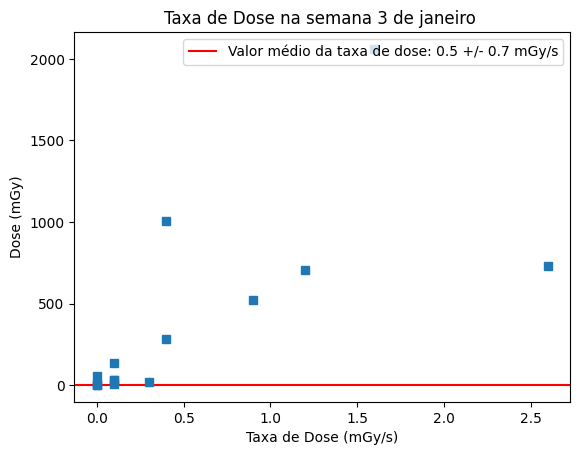

In [ ]:
import matplotlib.pyplot as plt

dados_kap = df_concat['KPA (uGym2)']
dados_dose = df_concat['Dose (mGy)']
dados_tempo = df_concat['Tempo (min)']
dados_taxa = df_concat['Taxa de Dose (mGy/s)']

#valor médio da taxa de dose
valormedio_tx = df_concat['Taxa de Dose (mGy/s)'].mean()
sd_tx = np.std(df_concat['Taxa de Dose (mGy/s)'])

# plotando o histograma
plt.errorbar (dados_taxa, dados_dose,sd_tx, linestyle='None',marker='s',capsize=3)
plt.axhline(valormedio_tx, color='red',label='Valor médio da taxa de dose: {a:.1f} +/- {b:.1f} mGy/s'.format(a=valormedio_tx,b=sd_tx))
plt.legend(loc='upper right')
plt.title('Taxa de Dose na semana {a} de {b} '.format(a=numero_semana,b=mes))
plt.xlabel('Taxa de Dose (mGy/s)')
plt.ylabel('Dose (mGy)')

plt.show()

### Salvando a imagem

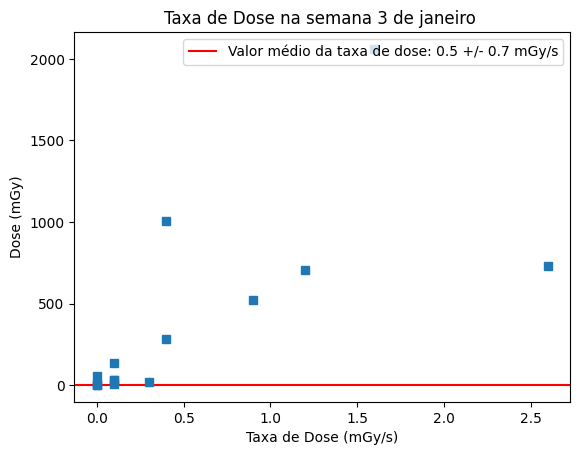

In [ ]:
plt.errorbar (dados_taxa, dados_dose,sd_tx, linestyle='None',marker='s',capsize=3)
plt.axhline(valormedio_tx, color='red',label='Valor médio da taxa de dose: {a:.1f} +/- {b:.1f} mGy/s'.format(a=valormedio_tx,b=sd_tx))
plt.legend(loc='upper right')
plt.title('Taxa de Dose na semana {a} de {b} '.format(a=numero_semana,b=mes))
plt.xlabel('Taxa de Dose (mGy/s)')
plt.ylabel('Dose (mGy)')

nome_da_imagem = "taxadedose{a}.png"
caminho_salvar_imagem = '/content/drive/MyDrive/dados_da_hemo/imagens_relatoriosdose'.format(a=ano,b=mes,c=numero_semana,d=nome_da_imagem)
plt.savefig(caminho_salvar_imagem)

## Plotando a distribuição de doses

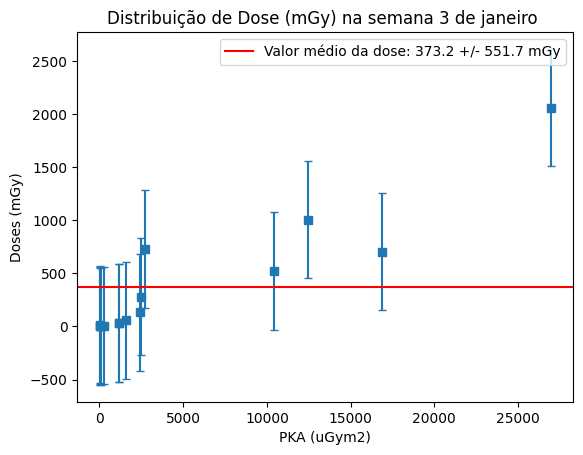

In [ ]:
doses = df_concat['Dose (mGy)']
pka = df_concat['KPA (uGym2)']

#Valor médio das doses
valor_medio_dose = df_concat['Dose (mGy)'].mean()
desvio_padrao_dose = np.std(df_concat['Dose (mGy)'])

# Criando um gráfico
plt.errorbar (pka, doses,desvio_padrao_dose, linestyle='None',marker='s',capsize=3)
plt.axhline(valor_medio_dose, color='red',label='Valor médio da dose: {a:.1f} +/- {b:.1f} mGy'.format(a=valor_medio_dose,b=desvio_padrao_dose))
plt.legend(loc='upper right')
plt.title('Distribuição de Dose (mGy) na semana {a} de {b} '.format(a=numero_semana,b=mes))
plt.xlabel('PKA (uGym2)')
plt.ylabel('Doses (mGy)')

# plt.errorbar(x, y, e, linestyle='None', marker='^')

plt.show()

### Salvando a imagem

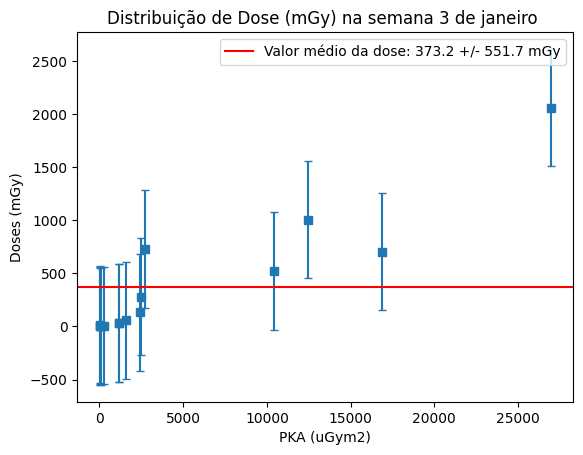

In [ ]:
# Criando um gráfico
plt.errorbar (pka, doses,desvio_padrao_dose, linestyle='None',marker='s',capsize=3)
plt.axhline(valor_medio_dose, color='red',label='Valor médio da dose: {a:.1f} +/- {b:.1f} mGy'.format(a=valor_medio_dose,b=desvio_padrao_dose))
plt.legend(loc='upper right')
plt.title('Distribuição de Dose (mGy) na semana {a} de {b} '.format(a=numero_semana,b=mes))
plt.xlabel('PKA (uGym2)')
plt.ylabel('Doses (mGy)')

nome_da_imagem = "distrib_doses.png"
caminho_salvar_imagem = '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/figuras/{d}'.format(a=ano,b=mes,c=numero_semana,d=nome_da_imagem)
plt.savefig(caminho_salvar_imagem)

## Estudando as doses de cada procedimento

In [ ]:
## Calcula o procedimento de maior dose

def obter_valor_maximo(dataframe, coluna_numerica, coluna_retorno):
    # Encontrar o índice da linha com o valor máximo na coluna numérica
    indice_maximo = dataframe[coluna_numerica].idxmax()

    # Obter o valor da coluna de retorno para a linha com o valor máximo na coluna numérica
    valor_retorno = dataframe.loc[indice_maximo, coluna_retorno]

    return valor_retorno

procedimento_maior_dose = obter_valor_maximo(df_concat,'Dose (mGy)','Tipo Procedimento')

In [ ]:
def media_desvio_dose_por_procedimento(df):
    # Agrupa o DataFrame pelos valores da coluna 'Tipo Procedimento' e calcula a média e o desvio padrão da coluna 'Dose (mGy)' para cada grupo
    media_dose = df.groupby('Tipo Procedimento')['Dose (mGy)'].mean()
    desvio_dose = df.groupby('Tipo Procedimento')['Dose (mGy)'].std()

    # Cria um novo DataFrame com os resultados
    df_media_desvio_dose = pd.DataFrame({'Media Dose (mGy)': media_dose, 'Desvio Padrao Dose (mGy)': desvio_dose}).reset_index()

    # Trata os valores NaN como zero e arredonda o desvio padrão para uma casa decimal
    df_media_desvio_dose['Desvio Padrao Dose (mGy)'] = df_media_desvio_dose['Desvio Padrao Dose (mGy)'].fillna(0).round(1)

    return df_media_desvio_dose

# Exemplo de uso da função
df_medias = media_desvio_dose_por_procedimento(df_concat)
df_medias

,Tipo Procedimento,Media Dose (mGy),Desvio Padrao Dose (mGy)
0,ANGIOPLASTIA INTRALUMINAL VASOS VISCERAIS C/ S...,2060.000000,0.0
1,ANGIOPLASTIA VASOS EXTREMIDADES INFERIOR DIR (...,134.000000,0.0
2,ANGIOPLASTIA VASOS EXTREMIDADES INFERIOR ESQ (...,58.000000,0.0
3,ARTERIOGRAFIA MEMBRO INFERIOR ESQ,1004.000000,0.0
4,ARTERIOGRAFIA P/ INVESTIGA??O DE ISQUEMIA CERE...,521.000000,0.0
5,ARTERIOGRAFIA P/ INVESTIGACAO HEMORRAGIA CEREB...,704.000000,0.0
6,CARD HDR,730.000000,0.0
7,EMBOLIZACAO SHUNT ARTERIO VENOSO,282.000000,0.0
8,EMBOLIZACAO TUMOR INTRA-CRANIANO OU DA CABECA ...,2.000000,0.0
9,IMPLANTACAO CATETER LONGA PERM. SEMI/TOTALMENT...,6.666667,3.2


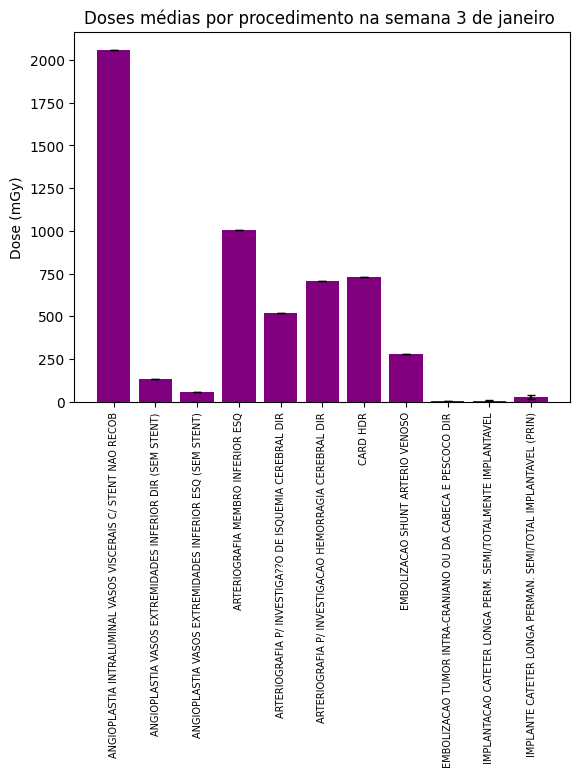

In [ ]:
# Criando um gráfico

tipo_dos_procedimentos = df_medias['Tipo Procedimento']
media_das_doses_proc = df_medias['Media Dose (mGy)']
desvio_padrao_das_doses = df_medias['Desvio Padrao Dose (mGy)']

plt.bar(tipo_dos_procedimentos, media_das_doses_proc, yerr=desvio_padrao_das_doses, linestyle='None', color='purple',capsize=3)
plt.title('Doses médias por procedimento na semana {a} de {b} '.format(a=numero_semana, b=mes))
plt.xticks(rotation=90, fontsize=7)
plt.ylabel('Dose (mGy)')

plt.show()

### Salvando a imagem

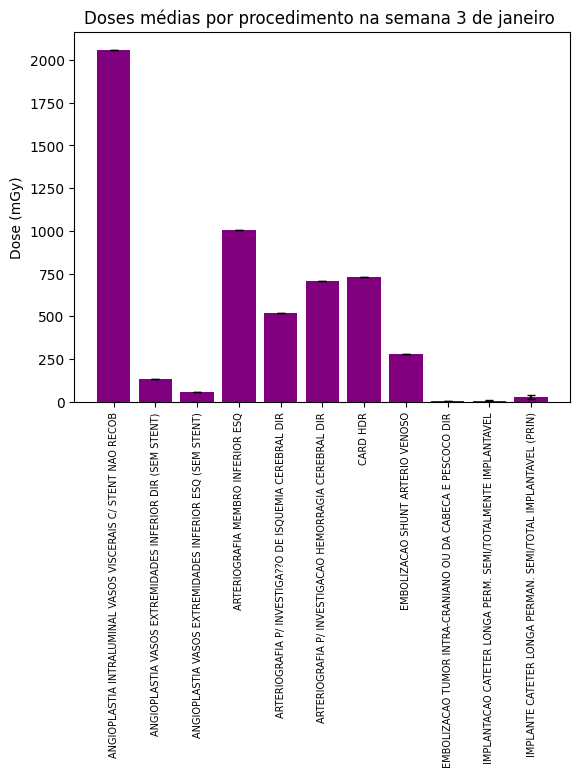

In [ ]:
plt.bar(tipo_dos_procedimentos, media_das_doses_proc, yerr=desvio_padrao_das_doses, linestyle='None', color='purple',capsize=3)
plt.title('Doses médias por procedimento na semana {a} de {b} '.format(a=numero_semana, b=mes))
plt.xticks(rotation=90, fontsize=7)
plt.ylabel('Dose (mGy)')

nome_da_imagem = "doses_exames.png"
caminho_salvar_imagem = '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/figuras/{d}'.format(a=ano,b=mes,c=numero_semana,d=nome_da_imagem)
plt.savefig(caminho_salvar_imagem, bbox_inches='tight')


## Frequência dos exames

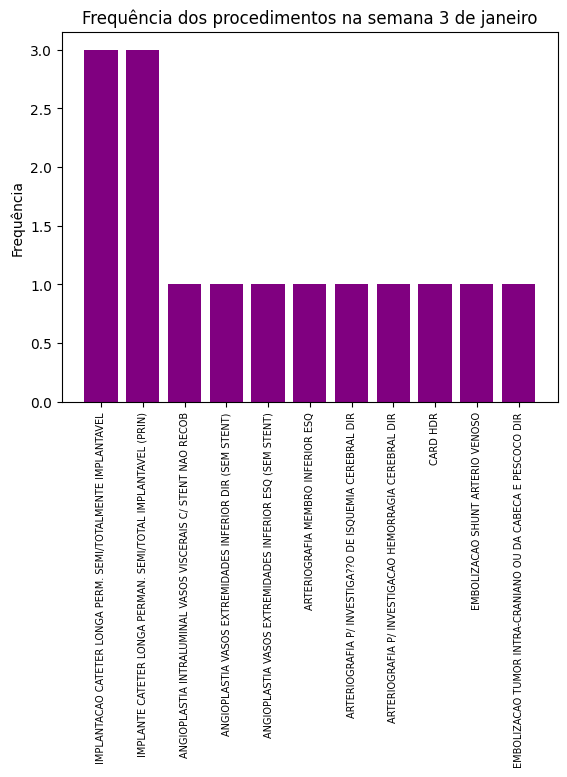

In [ ]:
# Contar a frequência de cada procedimento
df_concat2 = df_concat
df_concat2 = df_concat2.sort_values(by='Tipo Procedimento')
freq_procedimentos = df_concat2['Tipo Procedimento'].value_counts()

# Extrair os nomes dos procedimentos e suas frequências
procedimentos = freq_procedimentos.index
frequencias = freq_procedimentos.values

# Criar o gráfico de barras com a frequência dos procedimentos
plt.bar(procedimentos, frequencias, color='purple')
plt.title('Frequência dos procedimentos na semana {a} de {b}'.format(a=numero_semana, b=mes))
plt.xticks(rotation=90, fontsize=7)
plt.ylabel('Frequência')

plt.show()

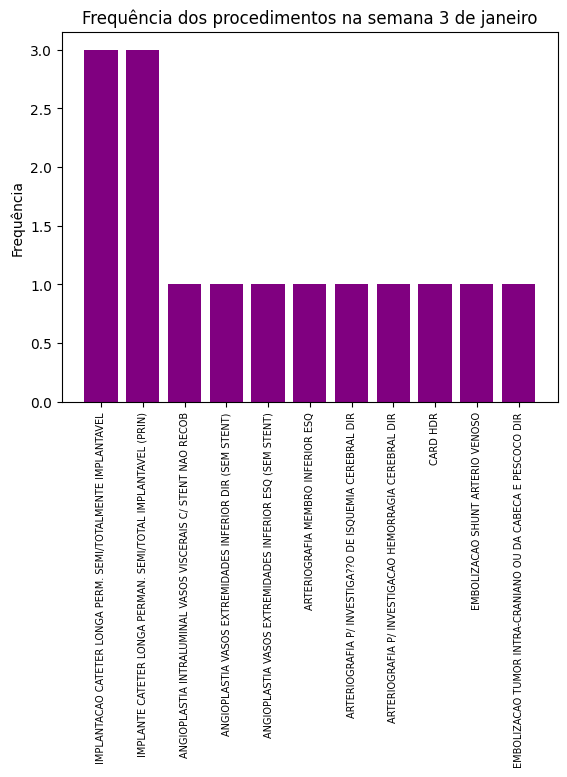

In [ ]:
# Criar o gráfico de barras com a frequência dos procedimentos
plt.bar(procedimentos, frequencias, color='purple')
plt.title('Frequência dos procedimentos na semana {a} de {b}'.format(a=numero_semana, b=mes))
plt.xticks(rotation=90, fontsize=7)
plt.ylabel('Frequência')

nome_da_imagem = "freq_exames.png"
caminho_salvar_imagem = '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/figuras/{d}'.format(a=ano,b=mes,c=numero_semana,d=nome_da_imagem)
plt.savefig(caminho_salvar_imagem,bbox_inches='tight')

## Coletando informações para o relatório

In [ ]:
dose_media_semanal = round(df_concat['Dose (mGy)'].mean(),1)
maior_dose_semanal = round(df_concat['Dose (mGy)'].max(),1)
desvio_dose_semanal = round(np.std(df_concat['Dose (mGy)']),1)

taxa_dose_media = round(df_concat['Taxa de Dose (mGy/s)'].mean(),1)
sd_taxadedose_semanal = round(np.std(df_concat['Taxa de Dose (mGy/s)']),1)

# Parte 4: Gerando os relatórios

## Instale as bibliotecas adicionais

In [ ]:
!pip install python-docx
from docx import Document
from docx.shared import Inches

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.4/237.4 kB 4.6 MB/s eta 0:00:00


## Defina as funções adicionais que utilizaremos

In [ ]:
def substituir_info_template(input_file, output_file, variaveis):
    doc = Document(input_file)

    for paragraph in doc.paragraphs:
        for key, value in variaveis.items():
            if '{{' + key + '}}' in paragraph.text:
                paragraph.text = paragraph.text.replace('{{' + key + '}}', value)

    doc.save(output_file)

def replace_placeholder_with_image(paragraph, placeholder, image_path, width=None, height=None):
    if placeholder in paragraph.text:
        index = paragraph.text.find(placeholder)
        before_text = paragraph.text[:index]
        after_text = paragraph.text[index + len(placeholder):]

        # Insere a imagem no parágrafo
        run_before = paragraph.add_run(before_text)
        run_img = paragraph.add_run()
        if width and height:
            run_img.add_picture(image_path, width=width, height=height)
        else:
            run_img.add_picture(image_path)
        run_after = paragraph.add_run(after_text)

        # Remove o texto original
        paragraph.clear()
        paragraph._element.append(run_before._element)
        paragraph._element.append(run_img._element)
        paragraph._element.append(run_after._element)

def inserir_imagem(input_file, output_file, placeholder, image_path, width=None, height=None):
    doc = Document(input_file)

## Preenchendo o template com as informações dessa semana (primeiramente, texto)

In [ ]:
variaveis = {
    'mes_referencia': mes,
    'semana_escolhida': numero_semana,
    'dose_media': str(dose_media_semanal),
    'maior_dose': str(maior_dose_semanal),
    'sd_dose_semanal': str(desvio_dose_semanal),
    'tx_dose': str(taxa_dose_media),
    'sd_dataxadedose': str(sd_taxadedose_semanal),
    'proc_maior_dose': procedimento_maior_dose
}

output_file = '/content/drive/MyDrive/dados_da_hemo/relatorios/Levantamento_Mensal_Hemodinamica_{a}_Mes_{b}_Semana{c}.docx'.format(a=ano,b=mes,c=numero_semana)
input_file = '/content/drive/MyDrive/dados_da_hemo/relatorios/template_relatorio.docx'
image_path = '/content/drive/MyDrive/dados_da_hemo/Arquivos/logos/logohcfmb.png'

substituir_info_template(input_file, output_file, variaveis)

## Preenchendo o template com as imagens da semana

In [ ]:
def substituir_chaves_por_imagens(doc_path, substituicoes):
    # Carregar o documento
    doc = Document(doc_path)

    # Percorrer todos os parágrafos do documento
    for paragraph in doc.paragraphs:
        # Verificar cada substituição
        for chave, imagem_path in substituicoes.items():
            chave_com_chaves = '{{' + chave + '}}'
            # Se a chave estiver no parágrafo
            if chave_com_chaves in paragraph.text:
                # Dividir o texto do parágrafo antes e depois da chave
                antes, chave, depois = paragraph.text.partition(chave_com_chaves)

                # Limpar o texto do parágrafo
                paragraph.clear()

                # Adicionar a parte antes da chave, a imagem e a parte depois da chave
                paragraph.add_run(antes)
                paragraph.add_run().add_picture(imagem_path)
                paragraph.add_run(depois)

    # Determinar o diretório do documento original
    original_dir = os.path.dirname(doc_path)

    # Definir o nome do arquivo atualizado
    updated_filename = 'Levantamento de Dose Hemodinamica - Semana {a} de {b} de {c}.docx'.format(a=numero_semana,b=mes,c=ano)

    # Criar o caminho completo para o documento atualizado
    updated_doc_path = os.path.join(original_dir, updated_filename)

    # Salvar o documento atualizado no mesmo diretório do documento original
    doc.save(updated_doc_path)
    os.remove(output_file)

# Exemplo de uso
substituicoes = {
    'graficodose': '/content/drive/MyDrive/dados_da_hemo/imagens_relatoriosdose/distribuicaodosemensal.png'.format(a=ano,b=mes,c=numero_semana),
    # 'graficotaxadose':  '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/figuras/taxadedose.png'.format(a=ano,b=mes,c=numero_semana),
    'graficodoseprocedimento':  '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/figuras/doses_exames.png'.format(a=ano,b=mes,c=numero_semana),
    'graficofreqprocedimento': '/content/drive/MyDrive/dados_da_hemo/{a}/{b}/semana{c}/figuras/freq_exames.png'.format(a=ano,b=mes,c=numero_semana)
}

substituir_chaves_por_imagens(output_file, substituicoes)

